In [35]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, RobustScaler

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["figure.figsize"] = (12, 6)

## 데이터 셋

In [36]:
class TimeSeriesDataset(Dataset):
    def __init__(self, csv_file="data/SBUX.csv", seq_length=10, train_ratio=0.8, is_train=True):
        self.seq_length = seq_length
        self.is_train = is_train

        df = pd.read_csv(csv_file)
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.sort_values("Date")
        df = self._add_techinical_indicators(df)

        features_cols = ["Close", "Volume", "MA_5", "MA_20", 
                         "RSI", "Volatility", "Price_Change", "Volume_MA"]
        
        data = df[features_cols].values

        # 결측값 처리
        data_df = pd.DataFrame(data)
        data = data_df.ffill().bfill().values
        
        self.scaler = RobustScaler()
        scaled_data = self.scaler.fit_transform(data)

        X, y = self._create_sequences(scaled_data, seq_length)

        train_size = int(len(X) * train_ratio)

        if self.is_train:
            self.X = torch.FloatTensor(X[:train_size])
            self.y = torch.FloatTensor(y[:train_size])
            self.dates = df['Date'].iloc[seq_length : train_size + seq_length]
        else:
            self.X = torch.FloatTensor(X[train_size:])
            self.y = torch.FloatTensor(y[train_size:])
            self.dates = df['Date'].iloc[train_size + seq_length :]

    def _create_sequences(self, data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[i:i + seq_length]
            y = data[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)
    
    def _add_techinical_indicators(self, df):
        # 이동평균
        df["MA_5"] = df["Close"].rolling(window=5).mean()
        df["MA_20"] = df["Close"].rolling(window=20).mean()

        # RSI
        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        # 변동성
        df["Volatility"] = df["Close"].rolling(window=14).std()

        # 가격 변화율
        df["Price_Change"] = df["Close"].pct_change()

        # 거래량 이동평균
        df["Volume_MA"] = df["Volume"].rolling(window=10).mean()

        return df
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
seq_length = 10
batch_size = 16

train_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=True)
test_dataset = TimeSeriesDataset(seq_length=seq_length, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 학습모델

### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))

## 모델 학습

In [ ]:
input_size = 8
hidden_size = 50
output_size = 1
num_epochs = 100
learning_rate = 0.001
num_layers_bilstm = 2

In [ ]:
lstm_model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    lstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

lstm_model.eval()
lstm_test_predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = lstm_model(batch_X)
        lstm_test_predictions.append(outputs.cpu().numpy())

lstm_test_predictions = np.concatenate(lstm_test_predictions)
lstm_test_predictions_rescaled = train_dataset.scaler.inverse_transform(lstm_test_predictions)
y_test_rescaled = train_dataset.scaler.inverse_transform(test_dataset.y.cpu().numpy())

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16, 8])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([2, 8])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LSTM Epoch [10/100], Loss: 0.7335
LSTM Epoch [20/100], Loss: 0.2157
LSTM Epoch [30/100], Loss: 1.4216
LSTM Epoch [40/100], Loss: 0.3758
LSTM Epoch [50/100], Loss: 0.6719
LSTM Epoch [60/100], Loss: 0.1260
LSTM Epoch [70/100], Loss: 0.7005
LSTM Epoch [80/100], Loss: 4.8443
LSTM Epoch [90/100], Loss: 2.2089
LSTM Epoch [100/100], Loss: 2.3671


ValueError: non-broadcastable output operand with shape (49,1) doesn't match the broadcast shape (49,8)

## 평가 시각화

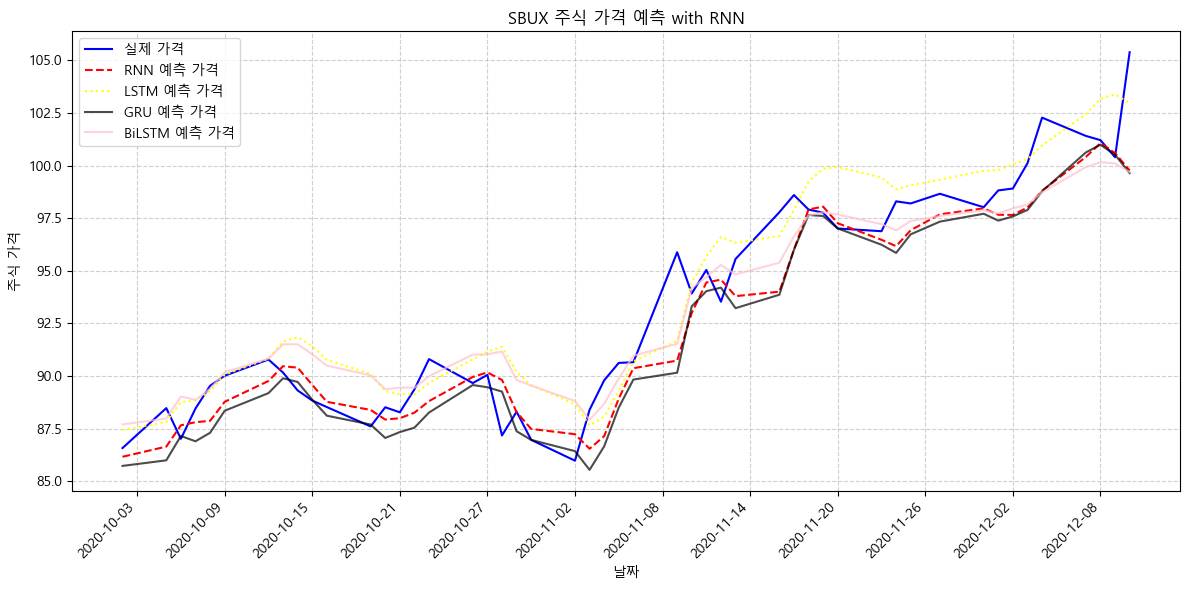

In [ ]:
plt.plot(test_dataset.dates, y_test_rescaled, label='실제 가격', color='blue')
plt.plot(test_dataset.dates, lstm_test_predictions_rescaled, label='LSTM 예측 가격', color='yellow', linestyle=':')
plt.xlabel('날짜')
plt.ylabel('주식 가격')
plt.title('SBUX 주식 가격 예측 with RNN')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=15))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
lstm_mse = np.mean((y_test_rescaled - lstm_test_predictions_rescaled)**2)
print(f'LSTM 모델 테스트 MSE (원래 스케일): {lstm_mse:.4f}')

RNN 모델 테스트 MSE (원래 스케일): 3.1161
LSTM 모델 테스트 MSE (원래 스케일): 3.1965
GRU 모델 테스트 MSE (원래 스케일): 3.8633
BiLSTM 모델 테스트 MSE (원래 스케일): 3.2388
